In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset
import numpy as np 
from torch.distributions.normal import Normal
from functorch import make_functional, vmap
import logging
import torch.nn.init as init
import matplotlib.pyplot as plt

In [2]:
import argparse
import argparse
import sys

# 检查并移除 Jupyter 传递的参数
if any('--f=' in arg for arg in sys.argv):
    # 移除包含 '--f=' 的所有参数
    sys.argv = [arg for arg in sys.argv if not arg.startswith('--f=')]
def parse_args():
    parser = argparse.ArgumentParser(description="Train a Mixture-of-Experts model.")
    parser.add_argument("--input_size",type=int,default=2,help="input size")
    parser.add_argument("--num_experts",type=int,default=2,help="number of experts")
    parser.add_argument("--hidden_size",type=int,default=20,help="hidden size")
    parser.add_argument("--depth",type=int,default=2,help="number of layers")
    parser.add_argument("--output_size",type=int,default=2,help="output size")
    parser.add_argument("--k",type=int,default=1,help="number of experts to select")
    parser.add_argument("--loss_coef",type=float,default=1e-2,help="coefficient for loss")
    parser.add_argument("--activation",type=str,default="ReLU",help="activation function")
    parser.add_argument("--batch_size",type=int,default=50,help="batch size")
    parser.add_argument("--num_samples",type=int,default=1000,help="number of samples")
    parser.add_argument("--epochs",type=int,default=40,help="number of epochs")
    parser.add_argument("--lr",type=float,default=1e-3,help="learning rate")
    parser.add_argument("--weight_decay",type=float,default=1e-4,help="weight decay")
    parser.add_argument("--device",type=str,default="cuda:7" if torch.cuda.is_available() else "cpu",help="device to use for training")
    parser.add_argument("--smooth_steps",type=int,default=3,help="number of steps for smooth mode")
    parser.add_argument("--smooth_lb",type=int,default=500,help="number lower bound of steps for smooth mode")
    parser.add_argument("--seed",type=int,default=1234) #1234
    return parser.parse_args()
args=parse_args()
torch.manual_seed(args.seed)

In [3]:
# Init model with MOE_model  (input_size, num_experts, hidden_size, depth, output_size,k=2,loss_coef=1e-2,activation=nn.Tanh()), MLP_model (input_size, hidden_size, depth, output_size, activation=nn.Tanh())


class SparseDispatcher(object):
    def __init__(self, num_experts, gates):
        """Create a SparseDispatcher."""

        self._gates = gates
        self._num_experts = num_experts
        # sort experts
        sorted_experts, index_sorted_experts = torch.nonzero(gates).sort(0)
        # drop indices
        _, self._expert_index = sorted_experts.split(1, dim=1)
        # get according batch index for each expert
        self._batch_index = torch.nonzero(gates)[index_sorted_experts[:, 1], 0]
        # calculate num samples that each expert gets
        self._part_sizes = (gates > 0).sum(0).tolist()
        # expand gates to match with self._batch_index
        gates_exp = gates[self._batch_index.flatten()]
        self._nonzero_gates = torch.gather(gates_exp, 1, self._expert_index)

    def dispatch(self, inp):
        inp_exp = inp[self._batch_index] 
        return torch.split(inp_exp, self._part_sizes, dim=0)

    def combine(self, expert_out, multiply_by_gates=True):
        stitched = torch.cat(expert_out, 0)

        if multiply_by_gates:
            stitched = stitched.mul(self._nonzero_gates)
        zeros = torch.zeros(self._gates.size(0), expert_out[-1].size(1), requires_grad=True, device=stitched.device)
        # combine samples that have been processed by the same k experts
        combined = zeros.index_add(0, self._batch_index, stitched.float())
        return combined

    def expert_to_gates(self):
        return torch.split(self._nonzero_gates, self._part_sizes, dim=0)

class Expert(nn.Module):
    """
    Expert network class. Using Tanh as activation function.

    Parameters:
    - input_size (int): The size of the input layer.
    - hidden_size (int): The size of the hidden layer.
    """
    def __init__(self,input_size,hidden_size,output_size,depth,activation=nn.Tanh()):
        self.depth=depth
        super(Expert, self).__init__()
        self.activation=activation
        layer_list = []
        layer_list.append(nn.Linear(input_size,hidden_size))  #[I,H]
        for i in range(self.depth-1):
            layer_list.append(nn.Linear(hidden_size,hidden_size))  #[H,H]
        layer_list.append(nn.Linear(hidden_size,output_size))  #[H,I] zhou's model
        self.net = nn.ModuleList(layer_list)
        self._init_weights()
        
    
    def _init_weights(self):
            for m in self.net.modules():
                if isinstance(m, nn.Linear):
                    init.xavier_normal_(m.weight)  # Xavier 正态分布初始化
                    if m.bias is not None:
                        init.zeros_(m.bias)
    def forward(self, y):
        for i, layer in enumerate(self.net[:-1]):
            y = layer(y)
            y = self.activation(y)
        y = self.net[-1](y)
        # y = self.activation(y) #zhou's model
        return y

class Gating(nn.Module):
    """
    Gating network class.Using Relu as activation function.

    Parameters:
    - input_size (int): The size of the input layer.
    - num_experts (int): The number of experts.
    - noise_epsilon (float): The noise epsilon value. default is 1e-4.
    """
    def __init__(self,input_size,num_experts,noise_epsilon=1e-6,gamma=1,R=1):
        super(Gating, self).__init__()
        self.net=nn.Sequential(
            # nn.Linear(input_size,num_experts)
            nn.Linear(input_size,num_experts*5),
            # nn.Tanh(),
            # nn.Linear(num_experts*5,num_experts*5),
            nn.ReLU(),
            nn.Linear(num_experts*5,num_experts),
            #[I,H]
        )
        self.noisy=nn.Linear(input_size,num_experts)
        self.softplus = nn.Softplus()
        self.noise_epsilon=noise_epsilon
        
        

                
        # self.udi_init(self.net[0], gamma, R)
        # self.net[0].udi_initialized = True
    def udi_init(self, layer, gamma, R):
            # 取出层参数
            weight = torch.randn_like(layer.weight)  # 随机方向
            # 每一行归一化到单位球面（a_j）
            weight = F.normalize(weight, p=2, dim=1)
            # 可选缩放 γ
            layer.weight.data = gamma * weight
            # 偏置均匀分布在 [0, R]
            layer.bias.data.uniform_(0.0, R)
            

    def forward(self,x,train):
        """ 
        - train (bool): Whether to train the model. Only add the noise when training.
        """
        gates=self.net(x)
        noisy_stddev=None 
        # if train:
        #     noisy_stddev=self.softplus(self.noisy(x)) + self.noise_epsilon 
        #     std = torch.randn_like(gates)  
        #     output= gates + noisy_stddev * std
        # else:
        #     output = gates
        output=gates
        
        return output, gates,noisy_stddev#[E,] noisy - clean-nosiy_stddev

class MoE(nn.Module):
    """MOE Block 

    Parameters:
    - input_size (int): The size of the input layer.
    - num_experts (int): The number of experts.
    - hidden_size (int): The size of the hidden layer.
    """
    def __init__(self,input_size,num_experts,hidden_size,depth,output_size,k=2,loss_coef=1e-2,activation=nn.Tanh(),epsilon=1e-0):
        super(MoE, self).__init__()
        self.k=k
        self.depth = depth
        self.smooth=False
        self.loss_coef = loss_coef
        self.num_experts = num_experts
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.epsilon = epsilon
        self.experts = nn.ModuleList(
            [Expert(self.input_size,self.hidden_size,self.output_size,self.depth,activation) for _ in range(num_experts)]
            )
        self.register_buffer("mean", torch.tensor([0.0]))
        self.register_buffer("std", torch.tensor([1.0]))
        self.gates_check=None
        self.softmax = nn.Softmax(dim=-1)
        self.gating_network = Gating(self.input_size,self.num_experts)
        self.tau1 ,self.tau2=nn.Parameter(torch.tensor(1e-1)),nn.Parameter(
            torch.tensor(1e-1))
        self.tau1.requires_grad , self.tau2.requires_grad= True,True
        

    def smoothing(self,step,step_lb):
        # cross train  -> soft
        self.smooth = not self.smooth
        if step >=step_lb:
            self.smooth =True

        
    def _prob_in_top_k(self, clean_values, noisy_values, noise_stddev, noisy_top_values):
        """Helper function to NoisyTopKGating.
        Computes the probability that value is in top k, given different random noise.
        This gives us a way of backpropagating from a loss that balances the number
        of times each expert is in the top k experts per example.
        In the case of no noise, pass in None for noise_stddev, and the result will
        not be differentiable.
        Args:
        clean_values: a `Tensor` of shape [batch, n].
        noisy_values: a `Tensor` of shape [batch, n].  Equal to clean values plus
        normally distributed noise with standard deviation noise_stddev.
        noise_stddev: a `Tensor` of shape [batch, n], or None
        noisy_top_values: a `Tensor` of shape [batch, m].
        "values" Output of tf.top_k(noisy_top_values, m).  m >= k+1
        Returns:
        a `Tensor` of shape [batch, n].
        """
        batch = clean_values.size(0)
        m = noisy_top_values.size(1)
        top_values_flat = noisy_top_values.flatten()

        threshold_positions_if_in = torch.arange(batch, device=clean_values.device) * m + self.k            #[batch]
        threshold_if_in = torch.unsqueeze(torch.gather(top_values_flat, 0, threshold_positions_if_in), 1)   #[batch,1]
        is_in = torch.gt(noisy_values, threshold_if_in)
        threshold_positions_if_out = threshold_positions_if_in - 1
        threshold_if_out = torch.unsqueeze(torch.gather(top_values_flat, 0, threshold_positions_if_out), 1)
        # is each value currently in the top k.
        normal = Normal(self.mean, self.std)
        prob_if_in = normal.cdf((clean_values - threshold_if_in)/noise_stddev)
        prob_if_out = normal.cdf((clean_values - threshold_if_out)/noise_stddev)
        prob = torch.where(is_in, prob_if_in, prob_if_out)
        return prob #[batch,num_experts]

    def _gates_to_load(self, gates):
        """Compute the true load per expert, given the gates.
        The load is the number of examples for which the corresponding gate is >0.
        Args:
        gates: a `Tensor` of shape [batch_size, n]
        Returns:
        a float32 `Tensor` of shape [n]
        """
        return (gates > 0).sum(0)
    
    def cv_squared(self, x):
        """The squared coefficient of variation of a sample.
        Useful as a loss to encourage a positive distribution to be more uniform.
        Epsilons added for numerical stability.
        Returns 0 for an empty Tensor.
        Args:
        x: a `Tensor`.
        Returns:
        a `Scalar`.
        """
        eps = 1e-10
        # if only num_experts = 1

        if x.shape[0] == 1:
            return torch.tensor([0], device=x.device, dtype=x.dtype)
        return x.var() / (x.mean()**2 + eps)

    
    def topkGating(self,x,train):
            ## topk--> softmax
            noisy,clean,noisy_stddev=self.gating_network(x,train)
            values=noisy
            
            values=self.softmax(values)
            values, indices= torch.topk(values,k=self.k,dim=-1) 
            # top_logits,_=torch.topk(noisy,k=self.k+1,dim=-1) #values: [k,] indices: [k,] zhou's mode
            # values=values/(values.sum(1, keepdim=True) + 1e-8)  # normalization
            # values= values / (values.sum(1, keepdim=True) + 1e-8) 
            zeros= torch.zeros_like(noisy, requires_grad=True)
            gates=zeros.scatter(1, indices, values)
            ## softmax--> topk-->normalize
            # Gating = self.softmax(noisy)
            # values, indices= torch.topk(Gating,k=self.k,dim=-1) 
            # top_logits,_=torch.topk(Gating,k=self.k+1,dim=-1) #values: [k,] indices: [k,]
            # top_k_gates = values / (values.sum(1, keepdim=True) + 1e-8)  # normalization
            # zeros = torch.zeros_like(Gating, requires_grad=True)
            # gates = zeros.scatter(1, indices, top_k_gates)#Gating: [E,]
            #balance loss
            # if  train:
            #     load = (self._prob_in_top_k(clean, noisy, noisy_stddev, top_logits)).sum(0) #[num_experts,]
            # else:
            #     load = self._gates_to_load(gates)
            #     load=load.float()   #zhou'model
            load=0
                
            
            return gates,load

    def soft_topk(self,s: torch.Tensor,k: int): #,tau1: float = 5e-2,tau2: float = 1e-2
        
        s=F.softmax(s,dim=-1)
        diff = torch.unsqueeze(s,-1) - torch.unsqueeze(s,-2)
        sigma = torch.sigmoid(-diff / self.tau1)
        row_sum = sigma.sum(dim=-1) - 0.5
        r_tilde = 1.0 + row_sum
        eps=0.5    
        a = torch.sigmoid((k+eps - r_tilde) / self.tau2)     

        a=a*s
        # a=a/(a.sum(1, keepdim=True) + 1e-8)
        

        return a
    def forward(self,x,train):
        smooth=self.smooth
        if smooth:
            
            gates,_,_=self.gating_network(x,train)
            gates= self.soft_topk(gates, self.k)
            # gates= gates/(self.epsilon) # +1e-1*torch.abs(gates)
            # gates= self.softmax(gates)
            # gates= gates / (gates.sum(1, keepdim=True) + 1e-8) 
        else:
            gates,load= self.topkGating(x,train)
        
        self.gates_check=gates
        # if not train:
        #     # not train-> print gates
        #     gates_np = gates.detach().cpu().numpy()
        #     print("Gates:\n", np.array2string(gates_np, precision=4, suppress_small=True))
        importance=gates.sum(0) 
        ##new dispatcher
        dispatcher = SparseDispatcher(self.num_experts, gates)
        expert_inputs = dispatcher.dispatch(x)
        gates=dispatcher.expert_to_gates()
        expert_outputs = [self.experts[i](expert_inputs[i]) for i in range(self.num_experts)]
        y = dispatcher.combine(expert_outputs)
        #balance loss
        #batch wise
        loss_coef=self.loss_coef
        loss=self.cv_squared(importance) # + self.cv_squared(load) zhou'model
        loss*=loss_coef
        return y,loss

class MLP(nn.Module):
    def __init__(self, hidden_size,activation=nn.Tanh()):
        super(MLP, self).__init__()
        self.hidden_size = hidden_size
        self.model = nn.Sequential(
            nn.Linear(self.hidden_size, hidden_size),
            activation
        )

    def forward(self, x):
        x = self.model(x)
        return x

class MLP_model(nn.Module):
    def __init__(self, input_size, hidden_size, depth, output_size, activation=nn.Tanh()):
        super().__init__()
        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.depth       = depth
        self.output_size = output_size
        
        # 建层（建议每层各自一个激活实例）
        def make_act():
            return activation.__class__() if isinstance(activation, nn.Module) else activation

        layer1 = nn.Sequential(nn.Linear(input_size, hidden_size), make_act())
        blocks = [layer1] + [MLP(hidden_size, make_act()) for _ in range(depth - 1)] + [nn.Linear(hidden_size, output_size)]
        self.model = nn.ModuleList(blocks)
        self.apply(self._init)
        self._report_trainable()
        

    def _report_trainable(self):
        total = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"=== Trainable parameters ===\nTotal trainable params: {total}\n")

    @staticmethod
    def _init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight, gain=nn.init.calculate_gain('tanh'))
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x, normalize=True):
        # 保证 dtype/device 一致，防止外部是 float64/GPU 而 buffer 不一致
        
        y = x

        for i, layer in enumerate(self.model):
            y = layer(y)
        return y

class MOE_model(nn.Module):   
    def __init__(self, input_size, num_experts, hidden_size, depth, output_size,k=2,loss_coef=1e-2,activation=nn.Tanh()):
        super(MOE_model, self).__init__()
        self.input_size = input_size
        self.num_experts = num_experts
        self.hidden_size = hidden_size
        self.depth = depth
        self.output_size = output_size
        self.k=k
        self.loss_coef=loss_coef
        self.moe=MoE(input_size, num_experts, hidden_size,depth,output_size,self.k,self.loss_coef,activation)
        self.model=self.moe

        
        self._init_weights()
        self._report_trainable()
        
    def frozen_beta(self):
            for p in self.Beta.parameters():
                p.requires_grad_(False)
    def _report_trainable(self):
            total = 0
            print("=== Trainable parameters ===")
            for name, p in self.named_parameters():
                if p.requires_grad:
                    n = p.numel()
                    total += n
            print(f"Total trainable params: {total}\n")
        
    def _init_weights(self):
        import torch.nn.init as init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # 如果是 UDI 初始化过的层，就跳过！
                if getattr(m, "udi_initialized", False):
                    continue
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)
    def forward(self, x):
        output,loss1=self.model(x, self.training)
        loss=loss1
        return output,loss
    

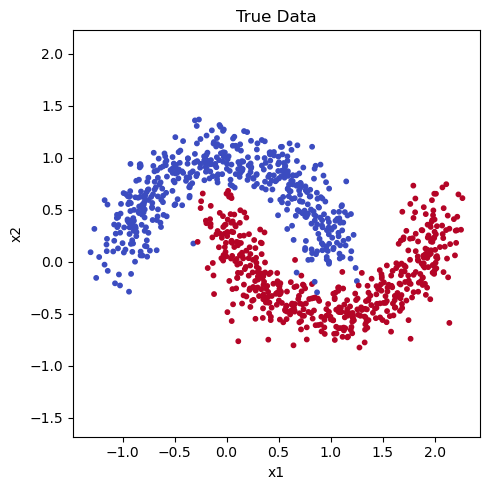

In [4]:
# load data
X_np, y_np = make_moons(n_samples=args.num_samples, noise=0.15, random_state=args.seed)
X=torch.from_numpy(X_np).float().to(args.device)
y=torch.from_numpy(y_np).long().to(args.device)
datasets=TensorDataset(X, y)
train_loader = DataLoader(datasets, batch_size=args.batch_size, shuffle=False)

plt.figure(figsize=(5,5))
plt.scatter(X_np[:,0], X_np[:,1], c=y_np, cmap="coolwarm", s=10)
plt.title("True Data")
plt.xlabel("x1"); plt.ylabel("x2")
plt.axis("equal")
plt.tight_layout()
plt.show()

In [5]:
# create model
def get_activation(name: str):
    name = name.lower()
    if name == "relu":
        return nn.ReLU()
    elif name == "tanh":
        return nn.Tanh()
    elif name == "leakyrelu":
        return nn.LeakyReLU(negative_slope=0.01)
    elif name == "gelu":
        return nn.GELU()
    elif name == "sin":
        return torch.sin
    else:
        raise ValueError(f"Unsupported activation: {name}")
activation= get_activation(args.activation)
MLP_model=MLP_model(args.input_size, args.hidden_size*2, args.depth, args.output_size, activation=activation).to(args.device)
MOE_model=MOE_model(args.input_size, args.num_experts, args.hidden_size, args.depth, 
                    args.output_size,args.k,args.loss_coef,activation=activation).to(args.device)

=== Trainable parameters ===
Total trainable params: 1842

=== Trainable parameters ===
Total trainable params: 1104



In [6]:
#  train init
def train_moe(model, train_loader, optimizer, epochs):
    model.train()
    running_loss = 0.0
    step_count=args.smooth_steps
    
    plt.ion()  # 开启交互模式，这样不会一直阻塞

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    ax_pred, ax_bound = axes
    sc1= ax_pred.scatter([],[])
    ax_pred.set_title("Pred vs True")
    ax_bound.set_title("Decision Boundary")
    
    
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # step_count -=1
            # if model.moe.smooth and step_count<=0:
            #     model.moe.smoothing(batch_idx,args.smooth_lb)
            #     step_count=args.smooth_steps
            # elif step_count<=0 :
            #     model.moe.smoothing(batch_idx,args.smooth_lb)
            #     step_count=args.smooth_steps
                
            output, aux_loss = model(data)
            loss = F.cross_entropy(output, target)
            loss=loss+ aux_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {running_loss:.6f}')
                running_loss = 0.0
                acc,y_pred,y_true = evaluate(model, train_loader)
                print('Train acc:', acc)
                plot_pred_vs_true(ax_pred,X_np, y_true, y_pred)
                plot_decision_boundary(ax_bound,model, X_np,y_true)
                fig.tight_layout()
                fig.canvas.draw()
                fig.canvas.flush_events()
                
        print(f'Average Loss: {running_loss:.6f}')
    
    
def train_mlp(model, train_loader, optimizer, epochs):
    model.train()
    running_loss = 0.0
    plt.ion()  # 开启交互模式，这样不会一直阻塞

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    ax_pred, ax_bound = axes
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 10 == 0:
                print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {running_loss:.6f}')
                running_loss = 0.0

                acc,y_pred,y_true = evaluate(model, train_loader,False)
                print('Train acc:', acc)
                plot_pred_vs_true(ax_pred,X_np, y_true, y_pred)
                plot_decision_boundary(ax_bound,model, X_np,y_true,False)
                fig.tight_layout()
                fig.canvas.draw()
                fig.canvas.flush_events()
            
        print(f'Average Loss: {running_loss:.6f}')
        
def plot_true_data(X_np, y_true):
    plt.figure(figsize=(5,5))
    plt.scatter(X_np[:,0], X_np[:,1], c=y_np, cmap="coolwarm", s=10)
    plt.title("True Data")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()
    
def plot_pred_vs_true(ax, X_np, y_true, y_pred):
    ax.cla()
    correct_mask = (y_true == y_pred)
    wrong_mask   = ~correct_mask

    ax.scatter(X_np[correct_mask,0], X_np[correct_mask,1],
               c=y_pred[correct_mask], cmap="coolwarm", s=10, label="Correct")
    ax.scatter(X_np[wrong_mask,0], X_np[wrong_mask,1],
               facecolors='none', edgecolors='k', s=40, label="Wrong")

    ax.set_title("Pred vs True")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()
    ax.axis("equal")

def evaluate(model, dataloader, moe=True,device=args.device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            if moe:
                logits,_ = model(x)    
            else: logits=model(x)# (B, num_classes)
            preds = logits.argmax(dim=1)  # (B,)

            correct += (preds == y).sum().item()
            total   += y.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    acc = correct / total
    y_pred  = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()
    return acc, y_pred,y_true 
    
def plot_decision_boundary(ax,model, X_np,y_true,moe=True, device=args.device):
    model.eval()
    X = X_np

    # 1. 生成一个网格
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]  # (300*300, 2)

    # 2. 模型预测这个网格的类别
    with torch.no_grad():
        grid_t = torch.from_numpy(grid).float().to(device)
        if moe:
            logits,_ = model(grid_t)
        else: logits=model(grid_t)
        
        preds = logits.argmax(dim=1).cpu().numpy()  # (N,)
        Z = preds.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    ax.scatter(X_np[:,0], X_np[:,1], c=y_true, cmap="coolwarm", s=10, edgecolor="k")
    ax.set_title("Decision Boundary")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.axis("equal")




iteration: 800
Epoch: 0 [0/1000] Loss: 0.652496
Train acc: 0.713
Epoch: 0 [500/1000] Loss: 6.461747
Train acc: 0.722
Average Loss: 5.534301
Epoch: 1 [0/1000] Loss: 6.121484
Train acc: 0.73
Epoch: 1 [500/1000] Loss: 5.778736
Train acc: 0.735
Average Loss: 4.908743
Epoch: 2 [0/1000] Loss: 5.421867
Train acc: 0.745
Epoch: 2 [500/1000] Loss: 4.990532
Train acc: 0.758
Average Loss: 4.229146
Epoch: 3 [0/1000] Loss: 4.663077
Train acc: 0.771
Epoch: 3 [500/1000] Loss: 4.085503
Train acc: 0.782
Average Loss: 3.662303
Epoch: 4 [0/1000] Loss: 4.021336
Train acc: 0.787
Epoch: 4 [500/1000] Loss: 3.465712
Train acc: 0.798
Average Loss: 3.310346
Epoch: 5 [0/1000] Loss: 3.623789
Train acc: 0.802
Epoch: 5 [500/1000] Loss: 3.081942
Train acc: 0.815
Average Loss: 3.113156
Epoch: 6 [0/1000] Loss: 3.392841
Train acc: 0.834
Epoch: 6 [500/1000] Loss: 2.849270
Train acc: 0.852
Average Loss: 2.937859
Epoch: 7 [0/1000] Loss: 3.198364
Train acc: 0.862
Epoch: 7 [500/1000] Loss: 2.677891
Train acc: 0.868
Average L

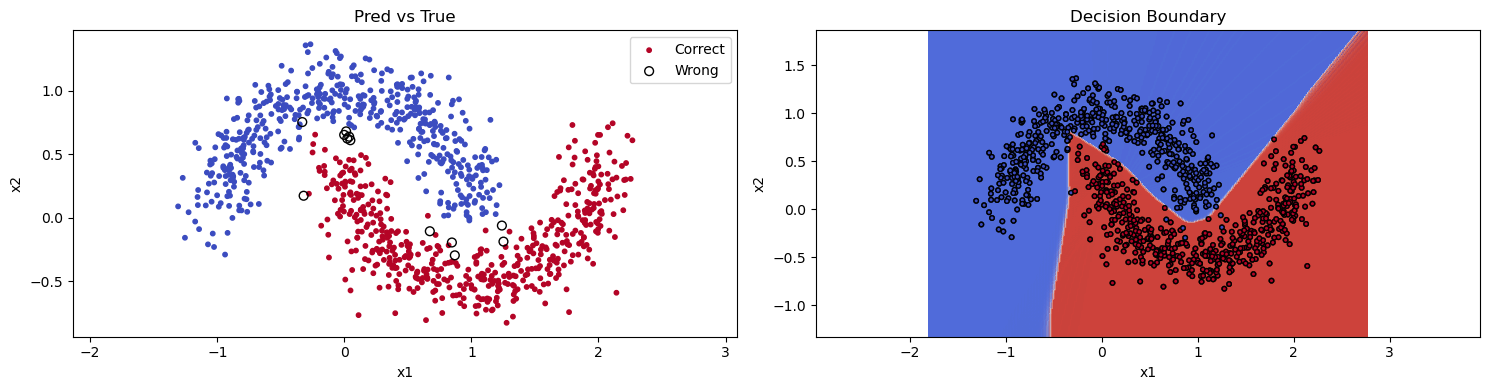

In [7]:
# train model


iteration= (args.num_samples // args.batch_size) * args.epochs
print("iteration:",iteration)
optimizer_moe= optim.Adam(MOE_model.parameters(), lr=args.lr ,weight_decay=args.weight_decay)
optimizer_mlp= optim.Adam(MLP_model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

train_moe(MOE_model,train_loader,  optimizer_moe, args.epochs)
plt.ioff()
plt.show() 

In [8]:
# cross training
# iteration= (args.num_samples // args.batch_size) * args.epochs
# print("iteration:",iteration)
# optimizer_moe= optim.Adam(MOE_model.parameters(), lr=args.lr ,weight_decay=args.weight_decay)
# optimizer_mlp= optim.Adam(MLP_model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

# train_moe(MOE_model,train_loader,  optimizer_moe, args.epochs)
# plt.ioff()
# plt.show() 

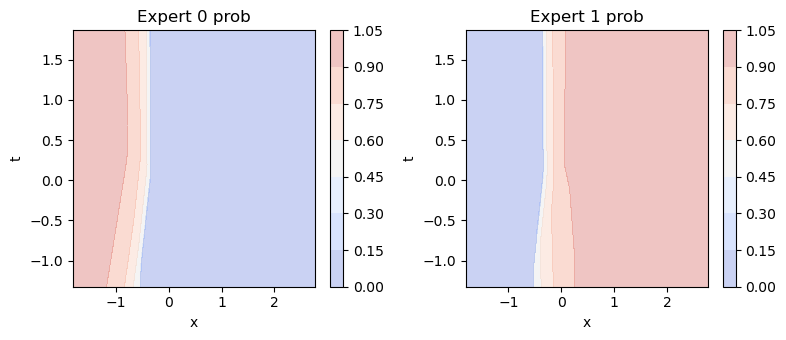

Parameter containing:
tensor(0.1000, device='cuda:7', requires_grad=True) Parameter containing:
tensor(0.1000, device='cuda:7', requires_grad=True)


In [9]:
def gates_image(model,X_test,device=args.device):
    """for moe mode MOE_modify_beta"""

    model.eval()
    moe=model.moe
    X_np=X.detach().cpu().numpy()   
    # 1. 生成一个网格
    x_min, x_max = X_np[:,0].min() - 0.5, X_np[:,0].max() + 0.5
    y_min, y_max = X_np[:,1].min() - 0.5, X_np[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 500),
        np.linspace(y_min, y_max, 500)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]  # (300*300, 2)
    # 2. 模型预测这个网格的类别
    with torch.no_grad():
        grid_t = torch.from_numpy(grid).float().to(device)
        if model.moe.smooth:
            gate_output,_,_=moe.gating_network(grid_t,train=False)
            gate_output =moe.soft_topk(gate_output, moe.k)
            # gate_output= gate_output/(moe.epsilon) #+1e-4*torch.abs(gates)
            # gate_output= moe.softmax(gate_output)
            # gate_output= gate_output / (gate_output.sum(1, keepdim=True) + 1e-8) 
        else:
            gate_output,_= moe.topkGating(grid_t,train=False)
    P = gate_output.detach().cpu().numpy()    
    # print("Shape", P.shape)# [N, E]
    E = P.shape[1]
    # 变形为 (nx, nt, E)
    P_grid = P.reshape(len(xx), len(yy), E)

    # 2.1 每个 expert 的热力图
    cols = min(E, 4)
    rows = int(np.ceil(E/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.5*rows), squeeze=False)
    for i in range(E):
        ax = axes[i//cols][i%cols]
        im=ax.contourf(xx, yy, P_grid[:,:,i], alpha=0.3, cmap="coolwarm")
        # im = ax.scatter(X_np[:,0], X_np[:,1], P_grid[:,:,i], levels=100, cmap='viridis', vmin=0, vmax=1)
        ax.set_title(f"Expert {i} prob")
        ax.set_xlabel("x"); ax.set_ylabel("t")
        fig.colorbar(im, ax=ax)
    plt.savefig("gates distribution.png")
    plt.tight_layout(); plt.show()
    return 
gates_image(MOE_model,X)
print(MOE_model.moe.tau1,MOE_model.moe.tau2)

In [10]:
# train mlp model
# plt.ion()  # 开启交互模式，这样不会一直阻塞


# train_mlp(MLP_model,train_loader,  optimizer_moe, args.epochs)
# plt.ioff()
# plt.show()
